<a href="https://colab.research.google.com/github/SiaMahmoudi/Object-Detector-in-TensorFlow-Using-Rotated-Bounding-box-Regression/blob/main/Rotated_Bounding_box_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import math as m
from math import pi, cos, sin

In [2]:
SKIP_NEGATIVES = True
NEGATIVE_CLASS = "No-Stair"

In [3]:
from tensorflow import keras


In [4]:
def xml_to_csv(path, skipNegatives):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        if root.find('object'):
            for member in root.findall('object'):
                bbx = member.find('robndbox')                
                cx = round(float(bbx.find('cx').text))
                cy = round(float(bbx.find('cy').text))
                w = round(float(bbx.find('w').text))
                h = round(float(bbx.find('h').text))
                angel = float(bbx.find('angle').text)
                label = member.find('name').text
                value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     cx,
                     cy,
                     w,
                     h,
                     m.cos(angel),
                     m.sin(angel)
                     )
                print(value)
                xml_list.append(value)
        elif not skipNegatives:
            value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        NEGATIVE_CLASS,
                        0,
                        0,
                        0,
                        0,
                        0,
                        0
                        )
            print(value)
            xml_list.append(value)

    column_name = ['filename', 'width', 'height',
                   'class', 'cx', 'cy', 'w', 'h', 'cos', 'sin']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [5]:
def main():
    datasets = ['Training', 'Validation']
    
    for ds in datasets:
        image_path = os.path.join(paths['Images'], ds)
        xml_df = xml_to_csv(image_path, SKIP_NEGATIVES)
        xml_df.to_csv('Data/{}_data.csv'.format(ds), index=None)
        print('Successfully converted xml to csv.')
        
   

In [6]:
paths = {
    'Images': os.path.join('Images'),
    'Data': os.path.join('Data')
    #'Training': os.path.join('Images','Training'),
   # 'Validation': os.path.join('Images','Validation')
 }

In [7]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [ ]:
!unzip '/content/Images/ALL.zip' -d '/content/Images'

In [55]:
import os
main()

('2022_03_05_15_03_39', 350, 400, 'UpStair', 180, 200, 180, 257, 1.0, 0.0)
('2022_02_24_15_48_17', 350, 400, 'UpStair', 73, 297, 128, 104, 1.0, 0.0)
('2022_02_27_15_05_40', 350, 400, 'UpStair', 224, 193, 121, 259, -0.9200721710490927, 0.3917488992467103)
('2022_03_01_17_08_52', 350, 400, 'UpStair', 242, 265, 195, 90, -0.8835915963173574, 0.46825835915373054)
('2022_03_01_17_08_52', 350, 400, 'UpStair', 241, 144, 169, 143, -0.8841150241124883, 0.4672693271963977)
('2022_03_05_14_54_35', 350, 400, 'UpStair', 92, 283, 85, 71, 0.9190227866251941, 0.3942044110149746)
('2022_03_05_14_26_50', 350, 400, 'UpStair', 148, 274, 180, 104, 0.8570349427092872, 0.5152582915153223)
('2022_03_05_14_57_52', 350, 400, 'UpStair', 67, 222, 129, 49, -0.6571652403152837, 0.7537465402383984)
('2022_03_01_17_04_03', 350, 400, 'UpStair', 138, 258, 221, 139, 1.0, 0.0)
('2022_03_05_14_45_51', 350, 400, 'UpStair', 139, 232, 233, 157, 0.47565835599085593, 0.8796301088389802)
('2022_03_05_14_29_04', 350, 400, 'DownSt

In [10]:
TRAINING_CSV_FILE = '/content/Data/Training_data.csv'
TRAINING_IMAGE_DIR = '/content/Images/Training'

Validation_CSV_FILE = '/content/Data/Validation_data.csv'
Validation_IMAGE_DIR = '/content/Images/Validation'

In [11]:
training_image_records = pd.read_csv(TRAINING_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)


In [12]:
train_images = []
train_targets = []
train_labels = []

In [13]:
classes = ["UpStair", "DownStair"]
width = 350
height = 400
num_classes = 2




In [14]:
for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, cx, cy, w, h, cos, sin) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename) + ".jpg"
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    
    
    cx = round(cx/ width, 2)
    cy = round(cy/ height, 2)
    w = round(w/ width, 2)
    h = round(h/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((cx, cy, w, h, cos, sin))
    train_labels.append(classes.index(class_name))

In [15]:
Valid_images = []
Valid_targets = []
Valid_labels = []

In [16]:
Validation_image_records = pd.read_csv(Validation_CSV_FILE)

Valid_image_path = os.path.join(os.getcwd(), Validation_IMAGE_DIR)

In [17]:
for index, row in Validation_image_records.iterrows():
    
    (filename, width, height, class_name, cx, cy, w, h, cos, sin) = row
    
    Valid_image_fullpath = os.path.join(Valid_image_path, filename) + ".jpg"
    Valid_img = keras.preprocessing.image.load_img(Valid_image_fullpath, target_size=(height, width))
    Valid_img_arr = keras.preprocessing.image.img_to_array(Valid_img)
    
    
    cx = round(cx/ width, 2)
    cy = round(cy/ height, 2)
    w = round(w/ width, 2)
    h = round(h/ height, 2)
    
    Valid_images.append(Valid_img_arr)
    Valid_targets.append((cx, cy, w, h, cos, sin))
    Valid_labels.append(classes.index(class_name))

In [18]:
train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

validation_images = np.array(Valid_images)
validation_targets = np.array(Valid_targets)
validation_labels = np.array(Valid_labels)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

In [90]:
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.RandomFlip("horizontal", name= 'bl_2')(base_layers)
base_layers = layers.RandomRotation(0.2)(base_layers)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_8')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_9')(base_layers)
base_layers = layers.Flatten(name='bl_10')(base_layers)

In [ ]:
input_layer

<KerasTensor: shape=(None, 400, 350, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch) 

In [91]:
#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(6, activation='sigmoid', name='bb_head')(locator_branch)

In [ ]:
locator_branch

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'bb_head')>

In [92]:
model = tf.keras.Model(input_layer,
           outputs=locator_branch)


In [93]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 400, 350, 3)]     0         
                                                                 
 bl_1 (Rescaling)            (None, 400, 350, 3)       0         
                                                                 
 bl_2 (RandomFlip)           (None, 400, 350, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 400, 350, 3)      0         
 tion)                                                           
                                                                 
 bl_4 (Conv2D)               (None, 400, 350, 16)      448       
                                                                 
 bl_5 (MaxPooling2D)         (None, 200, 175, 16)      0         
                                                           

In [94]:
#losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":tfa.losses.GIoULoss}
#losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":intersection_area}
losses = {"bb_head":tf.keras.losses.MSE}

In [95]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [96]:
trainTargets = {
    #"cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    #"cl_head": validation_labels,
    "bb_head": validation_targets
}

In [97]:
history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=3,
             epochs=20,
             shuffle=True,
             verbose=1)


Epoch 1/20
194/194 [==============================] - 5s 21ms/step - loss: 0.1646 - accuracy: 0.2031 - val_loss: 0.1506 - val_accuracy: 0.2211
Epoch 2/20
194/194 [==============================] - 4s 18ms/step - loss: 0.1556 - accuracy: 0.2203 - val_loss: 0.1484 - val_accuracy: 0.2263
Epoch 3/20
194/194 [==============================] - 4s 18ms/step - loss: 0.1560 - accuracy: 0.2203 - val_loss: 0.1482 - val_accuracy: 0.2474
Epoch 4/20
194/194 [==============================] - 4s 19ms/step - loss: 0.1534 - accuracy: 0.2238 - val_loss: 0.1534 - val_accuracy: 0.2421
Epoch 5/20
194/194 [==============================] - 4s 20ms/step - loss: 0.1557 - accuracy: 0.2151 - val_loss: 0.1488 - val_accuracy: 0.2263
Epoch 6/20
194/194 [==============================] - 4s 18ms/step - loss: 0.1551 - accuracy: 0.2272 - val_loss: 0.1480 - val_accuracy: 0.2421
Epoch 7/20
194/194 [==============================] - 4s 18ms/step - loss: 0.1542 - accuracy: 0.2289 - val_loss: 0.1488 - val_accuracy: 0.2263

In [98]:
a=model.predict(validation_images)

In [51]:
a[1][1]
 

0.67604357

In [99]:
b=validationTargets['bb_head']
b[0]

array([ 0.35      ,  0.65      ,  0.24      ,  0.65      , -0.76387006,
        0.64537007])

In [85]:
import numpy as np
from PIL import Image, ImageDraw
import math
import numpy.matlib as npm

In [86]:
def convert5Pointto8Point(cx_, cy_, w_, h_, cos_, sin_):

    #theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[cos_, sin_],
                  [-sin_, cos_]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    # add first point
    x1, y1 = bbox[0][0], bbox[1][0]
    # add second point
    x2, y2 = bbox[0][1], bbox[1][1]
    # add third point
    #x3, y3 = bbox[0][4], bbox[1][4]   
    # add forth point
    x3, y3 = bbox[0][2], bbox[1][2]
    # add fifth point
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]

In [100]:
IMAGE_PATH = os.path.join(paths['Images'], 'Validation', '/content/Images/Validation/2022_02_26_16_00_35.jpg')

In [101]:
i=6

Ground_truth=b[i]

Predict=a[i]




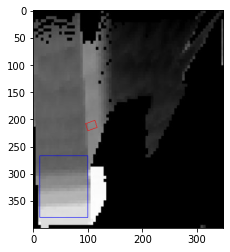

In [102]:
img = Image.open(IMAGE_PATH)
#img = Image.new('L', (width, height), 0)
polygon = convert5Pointto8Point(np.ceil(Ground_truth[0]*350), np.ceil(Ground_truth[1]*400), np.ceil(Ground_truth[2]*350), np.ceil(Ground_truth[3]*400), -Ground_truth[4], Ground_truth[5]) 
ImageDraw.Draw(img).polygon(polygon, outline='blue')   
polygon = convert5Pointto8Point(np.ceil(Predict[0]*350), np.ceil(Predict[1]*400), np.ceil(Predict[2]*350), np.ceil(Predict[3]*400), -Predict[4], Predict[5]) 
ImageDraw.Draw(img).polygon(polygon, outline='red')        
plt.imshow(img)
plt.show()